In [3]:
library(tidyverse)
library(forcats)
library(tidymodels)
library(rvest)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

name <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
          "oldpeak","slope","ca","thal","status")

colnames(heart_disease_data) <- name

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
heart_disease_data_as_factors <- heart_disease_data|>
  mutate(
    sex=ifelse(sex== 1, "Male","Female"),                                 #Classify male and female 
    cp=ifelse(cp == 1, "typical",                                         #Classify chest pain type
              ifelse(cp == 2, "atypical", 
                     ifelse(cp== 3, "non-anginal", 
                            "asymptomatic"))),
    fbs=ifelse(fbs == 0, "Normal","High"),                                #Classify blood sugar level
    restecg=ifelse(restecg==0,"Normal",                                   #Classify 
                   ifelse(restecg==1,"Abnormal","Definite")),
    exang=ifelse(exang==1,"yes","no"),
    slope=ifelse(slope == 1, "upsloping", 
                 ifelse(slope==2,"flat","downsloping")),
    ca=as_factor(ca),
    thal=ifelse(thal=="3.0","normal",
                ifelse(thal=="6.0","fixed defect","reversable defect")),
    status=ifelse(status==0,"absent","present"))|>                         # predicted variable
  mutate_if(is.character, as.factor)|>
  filter(ca!="?")

In [6]:
heart_scaled <- heart_disease_data_as_factors|>
  mutate(age=scale(age),
         trestbps=scale(trestbps),
         chol=scale(chol),
         thalach=scale(thalach),
         oldpeak=scale(oldpeak))

In [7]:
set.seed(1984)
heart_split_scaled <- initial_split(heart_scaled, prop = 0.75, strata = status)
heart_train_scaled <- training(heart_split_scaled)
heart_test_scaled <- testing(heart_split_scaled)

heart_vfold_scaled <- vfold_cv(heart_train_scaled, v = 5, strata = status)

In [8]:
names <- colnames(heart_train_scaled |> select(-status))


accuracies1 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

accuracies2 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

accuracies3 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

accuracies4 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

accuracies5 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

In [9]:
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

n_total <- length(names)

selected <- c()

set.seed(1984)
#for k=5
for (i in 1:n_total) {
  accs <- list()
  models <- list()
  for (j in 1:length(names)) {
    preds_new <- c(selected, names[[j]])
    model_string <- paste("status", "~", paste(preds_new, collapse="+"))
    heart_recipe_scaled <- recipe(as.formula(model_string), 
                            data = heart_train_scaled)
    acc <- workflow() |>
      add_recipe(heart_recipe_scaled) |>
      add_model(knn_spec_tune) |>
      tune_grid(resamples = heart_vfold_scaled, grid = 5) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      summarize(mx = max(mean))
    acc <- acc$mx |> unlist()
    accs[[j]] <- acc
    models[[j]] <- model_string
  }

  jstar <- which.max(unlist(accs))
  accuracies1 <- accuracies1 |> 
    add_row(size = i, 
            model_string = models[[jstar]], 
            accuracy = accs[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

In [17]:
accuracies_diff <- accuracies1|>
  mutate(diff=(accuracy-lag(accuracy))*100)

accuracies_diff

model=as.formula("status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps")

size,model_string,accuracy,diff
<int>,<chr>,<dbl>,<dbl>
1,status ~ oldpeak,0.7220202,NA
2,status ~ oldpeak+thal,0.7851515,6.3131313
3,status ~ oldpeak+thal+ca,0.8073737,2.2222222
4,status ~ oldpeak+thal+ca+cp,0.8431313,3.5757576
5,status ~ oldpeak+thal+ca+cp+slope,0.8478788,0.4747475
6,status ~ oldpeak+thal+ca+cp+slope+restecg,0.8565657,0.8686869
7,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps,0.8700000,1.3434343
8,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps+chol,0.8609091,-0.9090909
9,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps+chol+age,0.8566667,-0.4242424


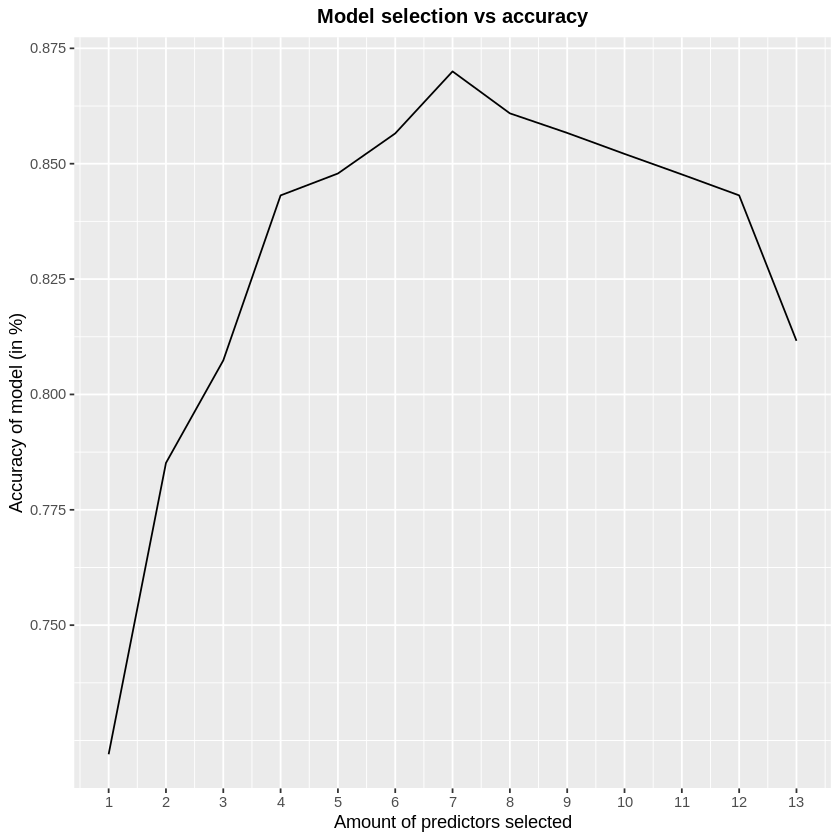

In [18]:
model_selection_plot <- accuracies1|>
  ggplot(aes(x=size,y=accuracy))+
  geom_line()+
  scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14))+
  scale_y_continuous(breaks=c(0.75,0.775,0.8,0.825,0.85,0.875))+
  labs(x="Amount of predictors selected",y="Accuracy of model (in %)",
       title="Model selection vs accuracy")+
  theme(plot.title=element_text(size=12,face="bold",hjust=0.5))

model_selection_plot

In [19]:
set.seed(1198)
heart_split <- initial_split(heart_disease_data_as_factors, prop = 0.75, strata = status)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [20]:
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular",neighbors = tune())|>
  set_engine("kknn")|>
  set_mode("classification")

heart_recipe <- recipe(model,data=heart_train)|>
  step_center(oldpeak,trestbps)|>
  step_scale(oldpeak,trestbps)

In [31]:
set.seed(1999)
heart_vfold <- vfold_cv(heart_train, v = 5, strata = status)

gridvals = tibble(neighbors = seq(from=1,to=50, by=2))

knn_tune_result <- workflow()|>
  add_recipe(heart_recipe)|>
  add_model(knn_spec_tune)|>
  tune_grid(resamples = heart_vfold, grid = gridvals)|>
  collect_metrics()|>
  filter(.metric=="accuracy")|>
  arrange(desc(mean))

best_k <- knn_tune_result|>
  slice(1)|>
  pull(neighbors)

knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = best_k)|>
  set_engine("kknn")|>
  set_mode("classification")

heart_fit <- workflow()|>
  add_recipe(heart_recipe)|>
  add_model(knn_spec)|>
  fit(data=heart_train)

result <- heart_fit|>
  predict(heart_test)|>
  bind_cols(heart_test)

result_metrics <- result|>
  metrics(truth=status,estimate = .pred_class)|>
  filter(.metric=="accuracy")

result_confusion <- result|>
  conf_mat(truth=status,estimate = .pred_class)

result_confusion

best_k

          Truth
Prediction absent present
   absent      37       6
   present      3      29

[1] 5